In [13]:
import img_scale
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import math
import cv2
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from matplotlib_scalebar.scalebar import ScaleBar #see https://github.com/ppinard/matplotlib-scalebar/blob/master/README.md

In [22]:
def make_rgb(name,size):    #make RGB image using u,g,i-band images

    path_r='./example/'+name+'/'+name+'_i.fits'     #such as './example/NGVS0002/NGVS0002_i.fits' 
    path_g='./example/'+name+'/'+name+'_g.fits'
    path_b='./example/'+name+'/'+name+'_u.fits'

    # Parameters
    blue_img = path_b
    green_img = path_g
    red_img = path_r
    min_val = -0.3
#    max_val = 20.0
    non_linear_fact = 1
    
#    sig_fract = 3.0     #parameters for estimate sky background in img_scale
#    per_fract = 5.0-4
#    max_iter = 100
    axis_tag = 'False'
#    axis_tag = 'True'
    box_size=20

   ##find maximum pixel value for scaling
    def findmax(arr,box_size):
        # arr: numpy array
        # box_size: integer of pixel range around image center
        width=arr.shape[1]
        max_val=np.amax(arr[int(width/2)-box_size:int(width/2)+box_size,int(width/2)-box_size:int(width/2)+box_size])
        return max_val

    
    # Blue image
    hdulist = fits.open(blue_img)
    data_size=len(hdulist[0].data)
    if data_size<=size:
        img_min=0
        img_max=data_size
        img_size=data_size
    else:
        img_min=int((data_size-size)/2)
        img_max=int((data_size+size)/2) 
        img_size=size
    img_header = hdulist[0].header
    img_data = hdulist[0].data[img_min:img_max,img_min:img_max]
    hdulist.close()
    width=img_data.shape[1]
    height=img_data.shape[0]
    
#    dim=[int(width*0.5),int(height*0.5)]

    print("Blue file = ", blue_img, "(", width, ",", height, ")")
    img_data_b = np.array(img_data, dtype=float)

    rgb_array = np.empty((height,width,3), dtype=float)

    #sky = np.median(numpy.ravel(img_data_b))
    #sky = np.mean(numpy.ravel(img_data_b))
#   sky, num_iter = img_scale.sky_median_sig_clip(img_data_b, sig_fract, per_fract, max_iter)
#   print("sky = ", sky, "(", num_iter, ") for blue image \
#    (", np.max(img_data_b), ",", np.min(img_data_b), ")")
#   img_data_b = img_data_b - sky

    b = img_scale.asinh(img_data_b, scale_min = min_val, scale_max = findmax(img_data_b,box_size),
                        non_linear=non_linear_fact)
    #Gaussian smooth for low surface brightness features if needed
    b1 = cv2.GaussianBlur(b,(3,3),1) 

    # Green image
    hdulist = fits.open(green_img)
    img_header = hdulist[0].header
    img_data = hdulist[0].data[img_min:img_max,img_min:img_max]
    hdulist.close()
    width=img_data.shape[1]
    height=img_data.shape[0]
    print("Green file = ", green_img, "(", width, ",", height, ")")
    img_data_g = np.array(img_data, dtype=float)
    
#   sky = np.median(numpy.ravel(img_data_g))
#   sky = np.mean(numpy.ravel(img_data_g))
#   sky, num_iter = img_scale.sky_median_sig_clip(img_data_g, sig_fract, per_fract, max_iter)
#   print("sky = ", sky, "(", num_iter, ") for green image \
#    (", np.max(img_data_g), ",", np.min(img_data_g), ")")
#   img_data_g = img_data_g - sky

    g = img_scale.asinh(img_data_g, scale_min = min_val, scale_max = findmax(img_data_g,box_size),
                        non_linear=non_linear_fact)
    g1 = cv2.GaussianBlur(g,(3,3),1)  

    # Red image
    hdulist = fits.open(red_img)
    img_header = hdulist[0].header
    img_data = hdulist[0].data[img_min:img_max,img_min:img_max]
    hdulist.close()
    width = img_data.shape[1]
    height = img_data.shape[0]
    print("Red file = ", red_img, "(", width, ",", height, ")")
    img_data_r = np.array(img_data, dtype=float)
    
#   sky = np.median(numpy.ravel(img_data_r))
#   sky = np.mean(numpy.ravel(img_data_r))
#   sky, num_iter = img_scale.sky_median_sig_clip(img_data_r, sig_fract, per_fract, max_iter)
#   print("sky = ", sky, "(", num_iter, ") for red image \
#    (", np.max(img_data_r), ",", np.min(img_data_r), ")")
#   img_data_r = img_data_r - sky

    r = img_scale.asinh(img_data_r, scale_min = min_val, scale_max = findmax(img_data_r,box_size),
                        non_linear=non_linear_fact)
    r1 = cv2.GaussianBlur(r,(3,3),1)

    # Generate RGB array for imshow
    rgb_array[:,:,0] = r
    rgb_array[:,:,1] = g
    rgb_array[:,:,2] = b    

    #add wcs for plotting with axis    
    w = WCS(path_g) 

   
    
    fig = plt.figure()
    ax = plt.subplot(projection=w)
    
    fsize= img_size/100
    plt.rcParams['font.size'] = fsize
    
    if axis_tag=='False': #output only images without axis   
        fig.set_size_inches(width/300, height/300) 
        ax.xaxis.set_major_locator(plt.NullLocator()) 
        ax.yaxis.set_major_locator(plt.NullLocator()) 
        plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        plt.axis('off')
        plt.margins(0,0)
        print("Plotting the RGB image of "+name+" (", width,",",height,")")    
        ax.imshow(rgb_array,origin='lower',interpolation='nearest')
        
        scalebar = ScaleBar(0.187, "''", dimension="angle",length_fraction=0.25,frameon=False,
                            location='lower right',scale_loc='top',sep=0,color='white')
        ax.add_artist(scalebar)  # Add scale_bar on the image
               
    elif axis_tag=='True':    
        print("Plotting the RGB image of "+name+" (", width,",",height,")")    
        ax.imshow(rgb_array,origin='lower',interpolation='nearest')
        ax.set_xlabel('R.A.')
        ax.set_ylabel('Dec.')
        ax.tick_params(axis='both')




Blue file =  ./example/NGVS0002/NGVS0002_u.fits ( 1600 , 1600 )
img_scale : asinh
Green file =  ./example/NGVS0002/NGVS0002_g.fits ( 1600 , 1600 )
img_scale : asinh
Red file =  ./example/NGVS0002/NGVS0002_i.fits ( 1600 , 1600 )
img_scale : asinh
Plotting the RGB image of NGVS0002 ( 1600 , 1600 )


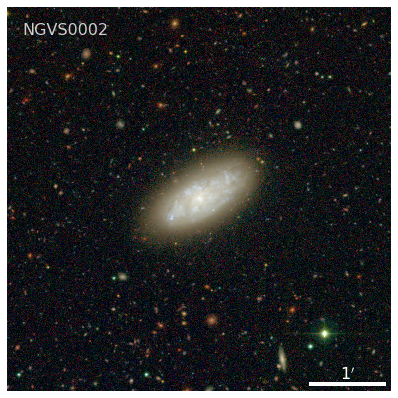

Blue file =  ./example/NGVS0006/NGVS0006_u.fits ( 1600 , 1600 )
img_scale : asinh
Green file =  ./example/NGVS0006/NGVS0006_g.fits ( 1600 , 1600 )
img_scale : asinh
Red file =  ./example/NGVS0006/NGVS0006_i.fits ( 1600 , 1600 )
img_scale : asinh
Plotting the RGB image of NGVS0006 ( 1600 , 1600 )


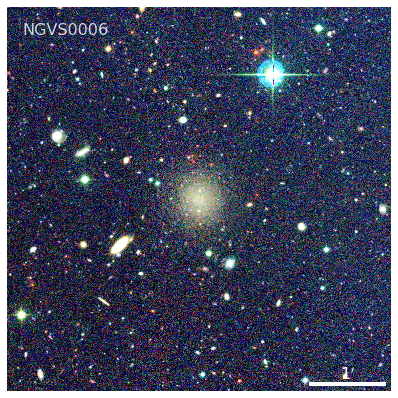

Blue file =  ./example/NGVS0016/NGVS0016_u.fits ( 1600 , 1600 )
img_scale : asinh
Green file =  ./example/NGVS0016/NGVS0016_g.fits ( 1600 , 1600 )
img_scale : asinh
Red file =  ./example/NGVS0016/NGVS0016_i.fits ( 1600 , 1600 )
img_scale : asinh
Plotting the RGB image of NGVS0016 ( 1600 , 1600 )


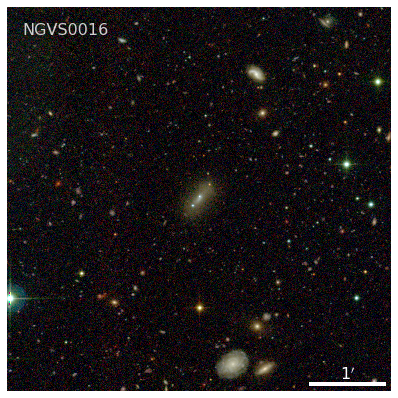

In [23]:
namelist=['NGVS0002','NGVS0006','NGVS0016']
for name in namelist:
    make_rgb(name,size=1600)
    ax = plt.gca()
    ax.text(0.04,0.94,name,horizontalalignment='left',verticalalignment='center',color='white',alpha=0.8,transform=ax.transAxes)
    plt.savefig(name+'.png',dpi=300)
    plt.show()